In [ ]:
!pip install transformers datasets torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load dataset
df = pd.read_csv("/content/dataset_with_readable_explanations.csv")

# Convert labels to text format
def format_label(row):
    if row["label"] == 1:
        return f"Phishing: {row['lime_explanation']}"
    else:
        return f"Benign: {row['lime_explanation']}"

df["target_text"] = df.apply(format_label, axis=1)

# Format input as "Classify: <features>"
df["input_text"] = df[["ip", "nb_qm", "nb_www", "ratio_digits_url", "phish_hints",
                        "nb_hyperlinks", "domain_in_title", "domain_age",
                        "google_index", "page_rank"]].astype(str).agg(" ".join, axis=1)
df["input_text"] = "Classify: " + df["input_text"]

# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(df["input_text"], df["target_text"], test_size=0.2, random_state=42)

# Convert to Hugging Face dataset format
train_data = Dataset.from_dict({"input_text": train_texts, "target_text": train_labels})
test_data = Dataset.from_dict({"input_text": test_texts, "target_text": test_labels})


In [ ]:
# Load T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Tokenize data
def tokenize_function(example):
    model_inputs = tokenizer(example["input_text"], padding="max_length", truncation=True, max_length=512)
    labels = tokenizer(example["target_text"], padding="max_length", truncation=True, max_length=128).input_ids
    model_inputs["labels"] = labels
    return model_inputs

train_dataset = train_data.map(tokenize_function, batched=True)
test_dataset = test_data.map(tokenize_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/6126 [00:00<?, ? examples/s]

Map:   0%|          | 0/1532 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./t5_phishing_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,  # Can be increased for better performance
    logging_dir="./logs",
    logging_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

# Train model
trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-1efa7f14081e>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: udaykrishna001 (udaykrishna001-amrita-vishwa-vidyapeetham) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.575500,0.035882
2,0.039300,0.027505
3,0.034300,0.022706
4,0.027800,0.021313
5,0.026400,0.020475
6,0.024100,0.019935
7,0.023600,0.018885
8,0.022700,0.018670


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=6128, training_loss=0.0738327379870975, metrics={'train_runtime': 689.7727, 'train_samples_per_second': 71.049, 'train_steps_per_second': 8.884, 'total_flos': 6632831006539776.0, 'train_loss': 0.0738327379870975, 'epoch': 8.0})

Accuracy: 0.9210
Precision: 0.9273
Recall: 0.9166
F1-Score: 0.9219
False Positive Rate: 0.0744
False Negative Rate: 0.0834
True Positives: 714, True Negatives: 697, False Positives: 56, False Negatives: 65


<ipython-input-6-37ba47c9e341>:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette="viridis")


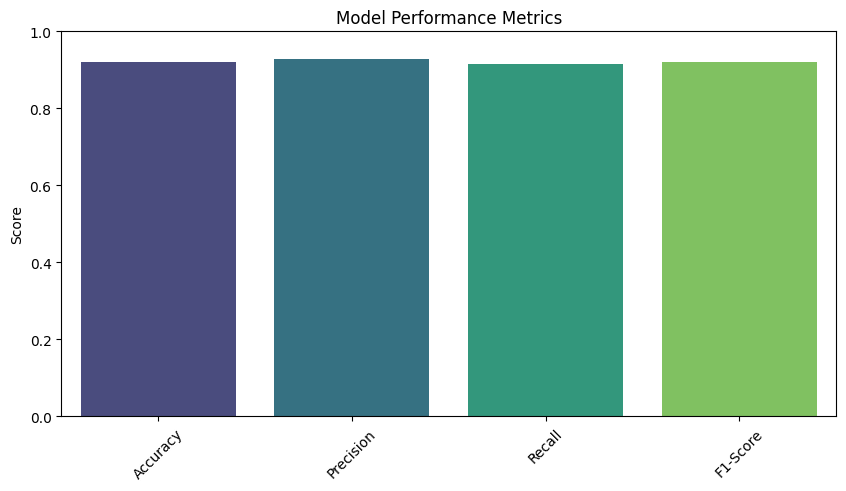

<ipython-input-6-37ba47c9e341>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=confusion_labels, y=confusion_values, palette="coolwarm")


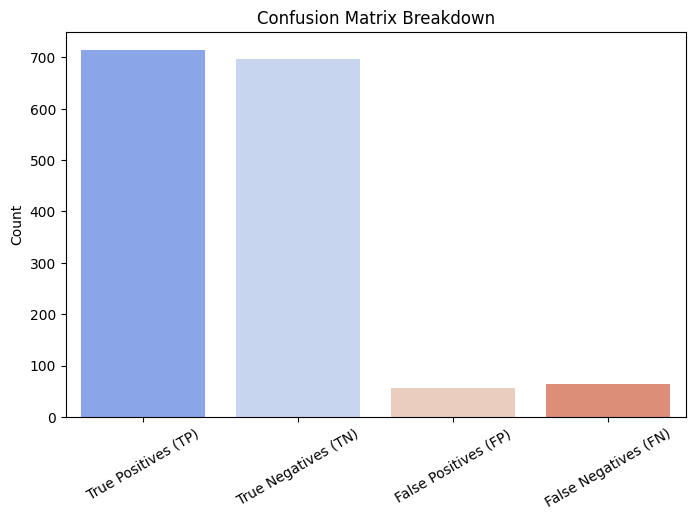

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def evaluate_model(model, dataset):
    # Move model to the same device as inputs
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize inputs and move them to the same device
    inputs = tokenizer(dataset["input_text"], return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move input tensors to device

    # Generate predictions
    with torch.no_grad():
        outputs = model.generate(**inputs)

    preds = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

    # Extract true labels
    true_labels = dataset["target_text"]

    # Convert predictions into categories
    pred_labels = ["Phishing" if "Phishing" in p else "Benign" for p in preds]
    true_labels = ["Phishing" if "Phishing" in t else "Benign" for t in true_labels]

    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="binary", pos_label="Phishing")

    # Compute confusion matrix to get false positive and false negative rates
    tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels, labels=["Benign", "Phishing"]).ravel()
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")
    print(f"False Negative Rate: {false_negative_rate:.4f}")
    print(f"True Positives: {tp}, True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}")

    # Plot Graph 1: Accuracy, Precision, Recall, F1-Score, FPR, FNR
    plt.figure(figsize=(10, 5))
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    values = [accuracy, precision, recall, f1]
    sns.barplot(x=metrics, y=values, palette="viridis")
    plt.ylim(0, 1)  # Set y-axis limit to 1
    plt.ylabel("Score")
    plt.title("Model Performance Metrics")
    plt.xticks(rotation=45)
    plt.show()

    # Plot Graph 2: Confusion Matrix Values (TP, TN, FP, FN)
    plt.figure(figsize=(8, 5))
    confusion_labels = ["True Positives (TP)", "True Negatives (TN)", "False Positives (FP)", "False Negatives (FN)"]
    confusion_values = [tp, tn, fp, fn]
    sns.barplot(x=confusion_labels, y=confusion_values, palette="coolwarm")
    plt.ylabel("Count")
    plt.title("Confusion Matrix Breakdown")
    plt.xticks(rotation=30)
    plt.show()

# Evaluate on test data
evaluate_model(model, test_dataset)


In [ ]:
model.save_pretrained("t5_finetuned_phishing")
tokenizer.save_pretrained("t5_finetuned_phishing")


('t5_finetuned_phishing/tokenizer_config.json',
 't5_finetuned_phishing/special_tokens_map.json',
 't5_finetuned_phishing/spiece.model',
 't5_finetuned_phishing/added_tokens.json')

In [ ]:
import shutil
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Define the directory to save the model
model_dir = "t5_finetuned_phishing"

# Save model and tokenizer
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

# Create a ZIP file
zip_filename = "t5_finetuned_phishing.zip"
shutil.make_archive(model_dir, 'zip', model_dir)

print(f"Model saved and zipped as {zip_filename}")


Model saved and zipped as t5_finetuned_phishing.zip


In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the trained model and tokenizer
model_dir = "t5_finetuned_phishing"
model = T5ForConditionalGeneration.from_pretrained(model_dir)
tokenizer = T5Tokenizer.from_pretrained(model_dir)

# Move model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def manual_predict():
    print("\nEnter the following values separated by commas:")
    print("ip, nb_qm, nb_www, ratio_digits_url, phish_hints, nb_hyperlinks, domain_in_title, domain_age, google_index, page_rank")

    # Get user input
    user_input = input("Enter values: ")

    # Convert input into the required format
    input_text = "Classify: " + user_input.replace(",", " ")

    # Tokenize and move to device
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Ensure all tensors are on the same device

    # Generate prediction with increased max_length
    with torch.no_grad():
        output = model.generate(**inputs, max_length=100)

    # Decode output
    prediction = tokenizer.decode(output[0], skip_special_tokens=True)

    # Display result
    print("\n🔍 **Prediction:**", prediction)

# Run manual prediction
manual_predict()



Enter the following values separated by commas:
ip, nb_qm, nb_www, ratio_digits_url, phish_hints, nb_hyperlinks, domain_in_title, domain_age, google_index, page_rank
Enter values: 0, 0, 0, 0, 0, 0.00128783, 1, 0.00085364, 1, 0

🔍 **Prediction:** Phishing: A higher page rank generally indicates a more trustworthy website. If Google has indexed the site, it is more likely to be legitimate. Certain words in the URL, commonly used in phishing attacks, increase the risk of being a phishing site. The occurrence of 'www' in an unusual place within the URL may indicate phishing. An unusually high number of hyperlinks on the page may suggest phishing behavior.
